In [5]:
# Input Labels
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_csv('insurence_data.csv')
df.head()

,age,affordibility,bought_insurance
0,22,1,0
1,25,0,0
2,47,1,1
3,52,0,0
4,46,1,1


In [7]:
df.describe()


,age,affordibility,bought_insurance
count,28.000000,28.000000,28.000000
mean,39.892857,0.678571,0.500000
std,15.497525,0.475595,0.509175
min,18.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000
50%,45.500000,1.000000,0.500000
75%,54.250000,1.000000,1.000000
max,62.000000,1.000000,1.000000


In [8]:
# Scaling Age Features 
df1 = df.copy()
df1['age'] = df.age / 100

Split train and test set

In [9]:
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(df1[ ['age' , 'affordibility'] ] , df1['bought_insurance'] , test_size=0.2 ,random_state=25 )

# Build Model with Tenserflow

In [10]:
model = keras.Sequential([
    keras.layers.Dense(  1, input_shape = (2 , )  , activation='sigmoid' ,  kernel_initializer='ones', bias_initializer='zeros')
] )

model.compile( 
              optimizer='adam',
              loss ='binary_crossentropy',
              metrics=['accuracy']
              )

model.fit(x_train , y_train , epochs=2000)

Epoch 1/2000
1/1 [==============================] - 1s 1s/step - loss: 0.7113 - accuracy: 0.5000
Epoch 2/2000
1/1 [==============================] - 0s 18ms/step - loss: 0.7110 - accuracy: 0.5000
Epoch 3/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.7106 - accuracy: 0.5000
Epoch 4/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7102 - accuracy: 0.5000
Epoch 5/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7098 - accuracy: 0.5000
Epoch 6/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.7094 - accuracy: 0.5000
Epoch 7/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.7091 - accuracy: 0.5000
Epoch 8/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.7087 - accuracy: 0.5000
Epoch 9/2000
1/1 [==============================] - 0s 30ms/step - loss: 0.7083 - accuracy: 0.5000
Epoch 10/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.7079 - accuracy: 0.5000
Epoch 11/20

In [11]:
model.evaluate(x_test , y_test)

1/1 [==============================] - 0s 343ms/step - loss: 0.5147 - accuracy: 0.6667


[0.5147148966789246, 0.6666666865348816]

In [12]:
y_pred = model.predict(x_test)
threshold = 0.5
y_pred_binary =  np.array(list(map(lambda x : 0 if x < threshold else 1 , y_pred)))
y_pred , y_pred_binary

1/1 [==============================] - 0s 231ms/step


(array([[0.6610701 ],
        [0.5149635 ],
        [0.32312724],
        [0.56699336],
        [0.6704036 ],
        [0.72345763]], dtype=float32),
 array([1, 1, 0, 1, 1, 1]))

In [13]:
from sklearn.metrics import  confusion_matrix , accuracy_score 
import seaborn as sns

print(accuracy_score(y_pred_binary , y_test))

0.6666666666666666


<Axes: >

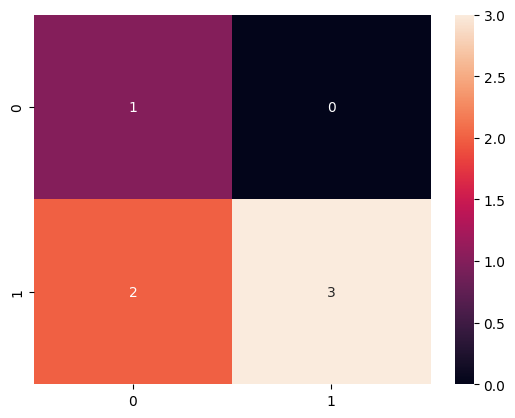

In [14]:
sns.heatmap(confusion_matrix(y_pred_binary , y_test) , annot=True)


In [15]:
coeff , bias = model.get_weights()
coeff , bias

(array([[2.0972233],
        [0.9670868]], dtype=float32),
 array([-1.284715], dtype=float32))

In [16]:
w1 =  coeff[0]
w2 =  coeff[1]
print('weigts - ' , w1 , w2)
print('bias - '  , bias )

weigts -  [2.0972233] [0.9670868]
bias -  [-1.284715]


# build custom prediction function using weights and bias

In [25]:
class MyNeuralNetwork:
    def __init__(self , initial_weight = 1, initial_bias  = 0, learning_rate = 0.5 ,loss_threshold = 0.42) -> None:
        
        # initialize weights and bias
        self.w1 = initial_weight
        self.w2 = initial_weight
        self.bias = initial_bias
        self.learning_rate = learning_rate
        self.loss_threshold = loss_threshold
        self.loss= 1
        self.accuracy = 0 
        
    #getting weights
    def get_weights(self):
        return [ [self.w1 , self.w2] , self.bias  ]
    
    # activation function 
    def sigmoid(self , y):
        return 1 / (1  + np.exp(-y))
    
    # cost function
    def log_loss(self  , y_pred  , y_true):
        epsilon = 1e-15
        y_pred = np.array( [ max(x,epsilon) if x==0 else min(x,1-epsilon)  for x in y_pred]   )
        y_true = np.array(y_true)
        
        return -np.mean(y_true*np.log(y_pred)+(1-y_true)*np.log(1-y_pred))
    
    # metrics calculating
    def accuracy_func(self , y_pred , y_true):
        y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]
        
        total_pred = len(y_pred)
        correct_pred = sum( [ 1 if true == pred else 0 for true,pred in zip(y_true,y_pred_binary)] )
        
        return correct_pred / total_pred 

        
    def gradient_descent(self , x_train , y_train , epoches):
        n = len(x_train)
        x1 = x_train.age
        x2 = x_train.affordibility
        
        for i in range(1,epoches+1):
            
            # weighted sum
            weighted_sum = self.w1 * x1 + self.w2 * x2 + self.bias 
            
            # convert weighted_sum to output using actvation function
            y_pred = self.sigmoid(weighted_sum)
            
            
            # find derivates of weights
            # d/dw = mean(  summation(  xi * (yi_p - yi_t )  ))
            dw1 = (np.dot( x1 , (y_pred - y_train)))  * (1/n)
            dw2 = (np.dot( x2 , (y_pred - y_train))) *  (1/ n)
            d_bias = np.mean(  y_pred - y_train)
            
            
             # adjust weights and bias to reduce the loss with help of learning_rate , derivated weights
            # new_w = w * learning_rate - dw
            
            self.w1 = self.w1 - self.learning_rate  * dw1
            self.w2 = self.w2 - self.learning_rate  * dw2
            self.bias = self.bias - self.learning_rate  * d_bias
            
            
            #calculating the loss btw the actual and predicted using loss function
            self.loss = self.log_loss(y_pred , y_train)
            self.accuracy = self.accuracy_func( y_pred , y_train) 
            
            if i%50==0:
                print (f'Epoch:{i}, w1:{self.w1}, w2:{self.w2}, bias:{self.bias}, loss:{self.loss} , accuracy : {self.accuracy}')
            
            if self.loss<=self.loss_threshold:
                print (f'Epoch:{i}, w1:{self.w1}, w2:{self.w2}, bias:{self.bias}, loss:{self.loss} , accuracy : {self.accuracy}')
                break
            
        return self.w1, self.w2, self.bias 
    
    def fit(self , x_train , y_train , epoches ):
        self.w1 ,self.w2 , self.bias = self.gradient_descent(x_train , y_train , epoches) 
        print(' loss :  ' , self.loss , ' accuracy : ' , self.accuracy)
        
    def predict(self ,x_test):
        x1 = x_test.age
        x2 = x_test.affordibility
    
        weighted_sum = self.w1 * x1 + self.w2 * x2 + self.bias         
        y_pred = self.sigmoid(weighted_sum)
        
        return y_pred
    
    def evaluate(self,x_test , y_test):
        y_pred = self.predict(x_test)
        
        loss = self.log_loss(y_pred , y_test)
        accuracy = self.accuracy_func( y_pred , y_test) 
        
        return {'loss':loss , 'accuracy' : accuracy}

In [26]:
my_model= MyNeuralNetwork()
my_model.fit(x_train , y_train , epoches=2000)

Epoch:50, w1:1.4890156230318012, w2:1.1025844223976542, bias:-1.2216210542672539, loss:0.5682796009861607 , accuracy : 0.6818181818181818
Epoch:100, w1:2.1871944491052364, w2:1.2918774898345378, bias:-1.6533819823304428, loss:0.5395530569489538 , accuracy : 0.6818181818181818
Epoch:150, w1:2.8371346977812824, w2:1.3687127378995887, bias:-1.9802293096782038, loss:0.5180278589849453 , accuracy : 0.7727272727272727
Epoch:200, w1:3.4316889691263146, w2:1.4037274192103975, bias:-2.252091504673362, loss:0.5008101251292182 , accuracy : 0.8636363636363636
Epoch:250, w1:3.972165348838788, w2:1.4235853514989025, bias:-2.489891856859742, loss:0.4867936645415293 , accuracy : 0.8636363636363636
Epoch:300, w1:4.462839550361659, w2:1.4385080284751603, bias:-2.703328362713941, loss:0.4752896446882009 , accuracy : 0.8636363636363636
Epoch:350, w1:4.9087498356574875, w2:1.4522911082498116, bias:-2.8974674516679864, loss:0.4657872590867513 , accuracy : 0.9090909090909091
Epoch:400, w1:5.314815619925096, 

In [27]:
my_model.get_weights()

[[10.028966655012473, 1.7885460410218221], -5.281127730886235]

In [31]:
my_model.evaluate(x_test , y_test)

{'loss': 0.19823379654340365, 'accuracy': 1.0}

In [28]:
#tenserflow weights
model.get_weights()

[array([[2.0972233],
        [0.9670868]], dtype=float32),
 array([-1.284715], dtype=float32)]

In [30]:
model.evaluate(x_test , y_test)

1/1 [==============================] - 0s 191ms/step - loss: 0.5147 - accuracy: 0.6667


[0.5147148966789246, 0.6666666865348816]